In [1]:
import cv2                  
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf

#sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
X=[]
Y=[]
IMG_SIZE=200
FLOWER_DAISY_DIR='flowers/daisy/'
FLOWER_SUNFLOWER_DIR='flowers/sunflower/'
FLOWER_TULIP_DIR='flowers/tulip/'
FLOWER_DANDI_DIR='flowers/dandelion/'
FLOWER_ROSE_DIR='flowers/rose/'
weights_path='./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [3]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(np.array(img))
        Y.append(str(label))
        

In [4]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 769/769 [00:02<00:00, 302.15it/s]


769


100%|██████████| 734/734 [00:02<00:00, 265.63it/s]


1503


100%|██████████| 1052/1052 [00:07<00:00, 146.74it/s]


2555


100%|██████████| 984/984 [00:03<00:00, 299.51it/s]


3539


100%|██████████| 784/784 [00:02<00:00, 301.29it/s]


4323


In [5]:
#fig,ax = plt.subplots(5,2)
#fig.set_size_inches(15,15)
#for i in range(5):
#    for j in range (2):
#        l = rn.randint(0,len(Y))
#        ax[i,j].imshow(X[l])
#        ax[i,j].set_title('Flower: '+Y[l])
#        
#plt.tight_layout()

le=LabelEncoder()
Y=le.fit_transform(Y)
Y=to_categorical(Y,5)
X = np.array(X)
X = X/255

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [6]:
batch_size=4
epochs=6
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3), pooling='avg')

model=Sequential()
model.add(base_model)
model.add(Dense(1000,activation='relu'))
model.add(Dense(5,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [8]:
lOCK_LAYER = 0
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])

for layer in base_model.layers[lOCK_LAYER:]:
    layer.trainable=True
for layer in base_model.layers[0:lOCK_LAYER]:
    layer.trainable=False
base_model.summary()

0 <keras.engine.input_layer.InputLayer object at 0x000001CC725990F0>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x000001CC72599160>
2 <keras.layers.convolutional.Conv2D object at 0x000001CC5DF37278>
3 <keras.layers.normalization.BatchNormalization object at 0x000001CC72599630>
4 <keras.layers.core.Activation object at 0x000001CC7D3B2550>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x000001CC7D3B23C8>
6 <keras.layers.pooling.MaxPooling2D object at 0x000001CC4A6B9C18>
7 <keras.layers.convolutional.Conv2D object at 0x000001CC4A698FD0>
8 <keras.layers.normalization.BatchNormalization object at 0x000001CC4AB08D30>
9 <keras.layers.core.Activation object at 0x000001CC4AB08EF0>
10 <keras.layers.convolutional.Conv2D object at 0x000001CC4AB29080>
11 <keras.layers.normalization.BatchNormalization object at 0x000001CC4AB3F0F0>
12 <keras.layers.core.Activation object at 0x000001CC4B098978>
13 <keras.layers.convolutional.Conv2D object at 0x000001CC4B143FD0>
14 <keras.layers.conv

activation_4 (Activation)       (None, 50, 50, 256)  0           add_1[0][0]                      
__________________________________________________________________________________________________
res2b_branch2a (Conv2D)         (None, 50, 50, 64)   16448       activation_4[0][0]               
__________________________________________________________________________________________________
bn2b_branch2a (BatchNormalizati (None, 50, 50, 64)   256         res2b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 50, 50, 64)   0           bn2b_branch2a[0][0]              
__________________________________________________________________________________________________
res2b_branch2b (Conv2D)         (None, 50, 50, 64)   36928       activation_5[0][0]               
__________________________________________________________________________________________________
bn2b_branc

__________________________________________________________________________________________________
bn4b_branch2b (BatchNormalizati (None, 13, 13, 256)  1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 13, 13, 256)  0           bn4b_branch2b[0][0]              
__________________________________________________________________________________________________
res4b_branch2c (Conv2D)         (None, 13, 13, 1024) 263168      activation_27[0][0]              
__________________________________________________________________________________________________
bn4b_branch2c (BatchNormalizati (None, 13, 13, 1024) 4096        res4b_branch2c[0][0]             
__________________________________________________________________________________________________
add_9 (Add)                     (None, 13, 13, 1024) 0           bn4b_branch2c[0][0]              
          

__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           activation_49[0][0]              
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [9]:
red_lr = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.2)

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                             verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
#History = model.fit(epochs = epochs, validation_data = (x_test,y_test),
#                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
#model.fit(x_train,y_train,epochs=epochs, validation_data = (x_test,y_test), verbose = 1,
#          steps_per_epoch=x_train.shape[0] // batch_size, validation_steps = x_test.shape[0] // batch_size)
#History = model.fit(x_train, y_train, epochs = epochs, batch_size = 64, verbose=1, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5005      
Total params: 25,641,717
Trainable params: 25,588,597
Non-trainable params: 53,120
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/6


204/864 [======>.......................] - ETA: 8:10:56 - loss: 1.4885 - acc: 0.25 - ETA: 4:09:50 - loss: 1.8415 - acc: 0.25 - ETA: 2:50:37 - loss: 1.9345 - acc: 0.16 - ETA: 2:10:08 - loss: 1.9403 - acc: 0.18 - ETA: 1:45:48 - loss: 1.8937 - acc: 0.20 - ETA: 1:29:33 - loss: 1.8672 - acc: 0.16 - ETA: 1:17:59 - loss: 1.8141 - acc: 0.17 - ETA: 1:09:32 - loss: 1.8537 - acc: 0.15 - ETA: 1:02:44 - loss: 1.8737 - acc: 0.13 - ETA: 57:19 - loss: 1.8362 - acc: 0.1500 - ETA: 52:52 - loss: 1.8526 - acc: 0.13 - ETA: 49:09 - loss: 1.8225 - acc: 0.14 - ETA: 46:00 - loss: 1.7895 - acc: 0.15 - ETA: 43:18 - loss: 1.7778 - acc: 0.16 - ETA: 40:58 - loss: 1.7925 - acc: 0.15 - ETA: 38:56 - loss: 1.7752 - acc: 0.15 - ETA: 37:07 - loss: 1.7589 - acc: 0.17 - ETA: 35:31 - loss: 1.7575 - acc: 0.16 - ETA: 34:04 - loss: 1.7531 - acc: 0.17 - ETA: 32:47 - loss: 1.7368 - acc: 0.18 - ETA: 31:38 - loss: 1.7453 - acc: 0.17 - ETA: 30:34 - loss: 1.7496 - acc: 0.18 - ETA: 29:36 - loss: 1.7448 - acc: 0.18 - ETA: 28:43 - loss

818/864 [===========================>..] - ETA: 2:53 - loss: 0.9296 - acc: 0.656 - ETA: 2:53 - loss: 0.9294 - acc: 0.655 - ETA: 2:52 - loss: 0.9282 - acc: 0.656 - ETA: 2:51 - loss: 0.9270 - acc: 0.656 - ETA: 2:51 - loss: 0.9262 - acc: 0.657 - ETA: 2:50 - loss: 0.9255 - acc: 0.657 - ETA: 2:49 - loss: 0.9243 - acc: 0.657 - ETA: 2:48 - loss: 0.9235 - acc: 0.658 - ETA: 2:48 - loss: 0.9241 - acc: 0.658 - ETA: 2:47 - loss: 0.9229 - acc: 0.658 - ETA: 2:46 - loss: 0.9235 - acc: 0.658 - ETA: 2:46 - loss: 0.9230 - acc: 0.658 - ETA: 2:45 - loss: 0.9224 - acc: 0.658 - ETA: 2:44 - loss: 0.9221 - acc: 0.658 - ETA: 2:43 - loss: 0.9219 - acc: 0.658 - ETA: 2:43 - loss: 0.9231 - acc: 0.658 - ETA: 2:42 - loss: 0.9233 - acc: 0.657 - ETA: 2:41 - loss: 0.9234 - acc: 0.657 - ETA: 2:41 - loss: 0.9230 - acc: 0.657 - ETA: 2:40 - loss: 0.9225 - acc: 0.657 - ETA: 2:39 - loss: 0.9225 - acc: 0.658 - ETA: 2:39 - loss: 0.9214 - acc: 0.658 - ETA: 2:38 - loss: 0.9211 - acc: 0.658 - ETA: 2:37 - loss: 0.9214 - acc: 0.658

864/864 [==============================] - ETA: 30s - loss: 0.8497 - acc: 0.68 - ETA: 29s - loss: 0.8500 - acc: 0.68 - ETA: 29s - loss: 0.8510 - acc: 0.68 - ETA: 28s - loss: 0.8508 - acc: 0.68 - ETA: 27s - loss: 0.8503 - acc: 0.68 - ETA: 27s - loss: 0.8495 - acc: 0.68 - ETA: 26s - loss: 0.8493 - acc: 0.68 - ETA: 25s - loss: 0.8490 - acc: 0.68 - ETA: 25s - loss: 0.8496 - acc: 0.68 - ETA: 24s - loss: 0.8496 - acc: 0.68 - ETA: 23s - loss: 0.8498 - acc: 0.68 - ETA: 23s - loss: 0.8494 - acc: 0.68 - ETA: 22s - loss: 0.8494 - acc: 0.68 - ETA: 21s - loss: 0.8486 - acc: 0.68 - ETA: 21s - loss: 0.8482 - acc: 0.68 - ETA: 20s - loss: 0.8478 - acc: 0.68 - ETA: 19s - loss: 0.8476 - acc: 0.68 - ETA: 19s - loss: 0.8472 - acc: 0.68 - ETA: 18s - loss: 0.8468 - acc: 0.68 - ETA: 17s - loss: 0.8464 - acc: 0.68 - ETA: 16s - loss: 0.8470 - acc: 0.68 - ETA: 16s - loss: 0.8478 - acc: 0.68 - ETA: 15s - loss: 0.8478 - acc: 0.68 - ETA: 14s - loss: 0.8484 - acc: 0.68 - ETA: 14s - loss: 0.8474 - acc: 0.68 - ETA: 13

204/864 [======>.......................] - ETA: 33:32 - loss: 1.2592 - acc: 0.50 - ETA: 21:11 - loss: 1.1984 - acc: 0.50 - ETA: 17:02 - loss: 0.9910 - acc: 0.58 - ETA: 14:58 - loss: 0.9294 - acc: 0.62 - ETA: 13:43 - loss: 0.7679 - acc: 0.70 - ETA: 12:54 - loss: 0.6655 - acc: 0.75 - ETA: 12:19 - loss: 0.5955 - acc: 0.78 - ETA: 11:51 - loss: 0.5272 - acc: 0.81 - ETA: 11:30 - loss: 0.5664 - acc: 0.77 - ETA: 11:12 - loss: 0.5528 - acc: 0.77 - ETA: 10:59 - loss: 0.5878 - acc: 0.75 - ETA: 10:47 - loss: 0.6151 - acc: 0.75 - ETA: 10:37 - loss: 0.6456 - acc: 0.75 - ETA: 10:29 - loss: 0.6104 - acc: 0.76 - ETA: 10:21 - loss: 0.6283 - acc: 0.76 - ETA: 10:14 - loss: 0.6129 - acc: 0.78 - ETA: 10:08 - loss: 0.6057 - acc: 0.79 - ETA: 10:03 - loss: 0.5927 - acc: 0.80 - ETA: 9:58 - loss: 0.5853 - acc: 0.8026 - ETA: 9:53 - loss: 0.5852 - acc: 0.787 - ETA: 9:49 - loss: 0.5694 - acc: 0.797 - ETA: 9:45 - loss: 0.5609 - acc: 0.795 - ETA: 9:42 - loss: 0.5409 - acc: 0.804 - ETA: 9:39 - loss: 0.5296 - acc: 0.81

819/864 [===========================>..] - ETA: 2:36 - loss: 0.5008 - acc: 0.831 - ETA: 2:35 - loss: 0.5001 - acc: 0.831 - ETA: 2:34 - loss: 0.5000 - acc: 0.831 - ETA: 2:34 - loss: 0.4993 - acc: 0.832 - ETA: 2:33 - loss: 0.4988 - acc: 0.832 - ETA: 2:32 - loss: 0.4986 - acc: 0.832 - ETA: 2:32 - loss: 0.4983 - acc: 0.832 - ETA: 2:31 - loss: 0.4977 - acc: 0.832 - ETA: 2:31 - loss: 0.4969 - acc: 0.832 - ETA: 2:30 - loss: 0.4962 - acc: 0.833 - ETA: 2:29 - loss: 0.4959 - acc: 0.833 - ETA: 2:29 - loss: 0.4961 - acc: 0.833 - ETA: 2:28 - loss: 0.4954 - acc: 0.833 - ETA: 2:27 - loss: 0.4948 - acc: 0.833 - ETA: 2:27 - loss: 0.4941 - acc: 0.834 - ETA: 2:26 - loss: 0.4939 - acc: 0.834 - ETA: 2:26 - loss: 0.4953 - acc: 0.833 - ETA: 2:25 - loss: 0.4953 - acc: 0.833 - ETA: 2:24 - loss: 0.4951 - acc: 0.833 - ETA: 2:24 - loss: 0.4947 - acc: 0.833 - ETA: 2:23 - loss: 0.4942 - acc: 0.833 - ETA: 2:22 - loss: 0.4951 - acc: 0.833 - ETA: 2:22 - loss: 0.4954 - acc: 0.833 - ETA: 2:21 - loss: 0.4961 - acc: 0.832

864/864 [==============================] - ETA: 27s - loss: 0.4741 - acc: 0.83 - ETA: 26s - loss: 0.4736 - acc: 0.83 - ETA: 26s - loss: 0.4740 - acc: 0.83 - ETA: 25s - loss: 0.4738 - acc: 0.83 - ETA: 24s - loss: 0.4745 - acc: 0.83 - ETA: 24s - loss: 0.4741 - acc: 0.83 - ETA: 23s - loss: 0.4739 - acc: 0.83 - ETA: 22s - loss: 0.4737 - acc: 0.83 - ETA: 22s - loss: 0.4733 - acc: 0.83 - ETA: 21s - loss: 0.4739 - acc: 0.83 - ETA: 21s - loss: 0.4736 - acc: 0.83 - ETA: 20s - loss: 0.4738 - acc: 0.83 - ETA: 19s - loss: 0.4748 - acc: 0.83 - ETA: 19s - loss: 0.4749 - acc: 0.83 - ETA: 18s - loss: 0.4746 - acc: 0.83 - ETA: 18s - loss: 0.4753 - acc: 0.83 - ETA: 17s - loss: 0.4750 - acc: 0.83 - ETA: 16s - loss: 0.4749 - acc: 0.83 - ETA: 16s - loss: 0.4748 - acc: 0.83 - ETA: 15s - loss: 0.4745 - acc: 0.83 - ETA: 14s - loss: 0.4743 - acc: 0.83 - ETA: 14s - loss: 0.4740 - acc: 0.83 - ETA: 13s - loss: 0.4742 - acc: 0.83 - ETA: 13s - loss: 0.4744 - acc: 0.83 - ETA: 12s - loss: 0.4755 - acc: 0.83 - ETA: 11

204/864 [======>.......................] - ETA: 8:51 - loss: 0.1722 - acc: 1.000 - ETA: 7:46 - loss: 0.3698 - acc: 1.000 - ETA: 8:12 - loss: 0.3444 - acc: 1.000 - ETA: 8:20 - loss: 0.3546 - acc: 1.000 - ETA: 8:27 - loss: 0.5337 - acc: 0.950 - ETA: 8:31 - loss: 0.4662 - acc: 0.958 - ETA: 8:34 - loss: 0.4648 - acc: 0.964 - ETA: 8:37 - loss: 0.4617 - acc: 0.937 - ETA: 8:37 - loss: 0.4768 - acc: 0.916 - ETA: 8:39 - loss: 0.4542 - acc: 0.925 - ETA: 8:39 - loss: 0.5215 - acc: 0.863 - ETA: 8:39 - loss: 0.5103 - acc: 0.854 - ETA: 8:39 - loss: 0.4761 - acc: 0.865 - ETA: 8:39 - loss: 0.4737 - acc: 0.857 - ETA: 8:40 - loss: 0.4558 - acc: 0.866 - ETA: 8:39 - loss: 0.4643 - acc: 0.859 - ETA: 8:39 - loss: 0.4873 - acc: 0.852 - ETA: 8:39 - loss: 0.4624 - acc: 0.861 - ETA: 8:38 - loss: 0.4472 - acc: 0.868 - ETA: 8:39 - loss: 0.4771 - acc: 0.850 - ETA: 8:38 - loss: 0.4665 - acc: 0.857 - ETA: 8:38 - loss: 0.4798 - acc: 0.852 - ETA: 8:38 - loss: 0.5332 - acc: 0.826 - ETA: 8:37 - loss: 0.5287 - acc: 0.822

819/864 [===========================>..] - ETA: 2:36 - loss: 0.3687 - acc: 0.872 - ETA: 2:35 - loss: 0.3686 - acc: 0.873 - ETA: 2:35 - loss: 0.3682 - acc: 0.873 - ETA: 2:34 - loss: 0.3698 - acc: 0.872 - ETA: 2:33 - loss: 0.3694 - acc: 0.872 - ETA: 2:33 - loss: 0.3700 - acc: 0.871 - ETA: 2:32 - loss: 0.3698 - acc: 0.872 - ETA: 2:32 - loss: 0.3710 - acc: 0.871 - ETA: 2:31 - loss: 0.3717 - acc: 0.871 - ETA: 2:30 - loss: 0.3720 - acc: 0.871 - ETA: 2:30 - loss: 0.3721 - acc: 0.871 - ETA: 2:29 - loss: 0.3719 - acc: 0.871 - ETA: 2:28 - loss: 0.3714 - acc: 0.871 - ETA: 2:28 - loss: 0.3719 - acc: 0.871 - ETA: 2:27 - loss: 0.3722 - acc: 0.870 - ETA: 2:27 - loss: 0.3717 - acc: 0.871 - ETA: 2:26 - loss: 0.3712 - acc: 0.871 - ETA: 2:25 - loss: 0.3708 - acc: 0.871 - ETA: 2:25 - loss: 0.3707 - acc: 0.871 - ETA: 2:24 - loss: 0.3703 - acc: 0.871 - ETA: 2:23 - loss: 0.3702 - acc: 0.871 - ETA: 2:23 - loss: 0.3702 - acc: 0.871 - ETA: 2:22 - loss: 0.3703 - acc: 0.871 - ETA: 2:22 - loss: 0.3699 - acc: 0.871

864/864 [==============================] - ETA: 27s - loss: 0.3640 - acc: 0.87 - ETA: 26s - loss: 0.3637 - acc: 0.87 - ETA: 26s - loss: 0.3636 - acc: 0.87 - ETA: 25s - loss: 0.3636 - acc: 0.87 - ETA: 24s - loss: 0.3634 - acc: 0.87 - ETA: 24s - loss: 0.3631 - acc: 0.87 - ETA: 23s - loss: 0.3630 - acc: 0.87 - ETA: 23s - loss: 0.3636 - acc: 0.87 - ETA: 22s - loss: 0.3632 - acc: 0.87 - ETA: 21s - loss: 0.3642 - acc: 0.87 - ETA: 21s - loss: 0.3645 - acc: 0.87 - ETA: 20s - loss: 0.3652 - acc: 0.87 - ETA: 19s - loss: 0.3653 - acc: 0.87 - ETA: 19s - loss: 0.3653 - acc: 0.87 - ETA: 18s - loss: 0.3653 - acc: 0.87 - ETA: 18s - loss: 0.3651 - acc: 0.87 - ETA: 17s - loss: 0.3667 - acc: 0.87 - ETA: 16s - loss: 0.3668 - acc: 0.87 - ETA: 16s - loss: 0.3672 - acc: 0.87 - ETA: 15s - loss: 0.3679 - acc: 0.87 - ETA: 14s - loss: 0.3681 - acc: 0.87 - ETA: 14s - loss: 0.3688 - acc: 0.87 - ETA: 13s - loss: 0.3684 - acc: 0.87 - ETA: 13s - loss: 0.3680 - acc: 0.87 - ETA: 12s - loss: 0.3684 - acc: 0.87 - ETA: 11

204/864 [======>.......................] - ETA: 8:50 - loss: 0.4579 - acc: 0.750 - ETA: 8:51 - loss: 0.3025 - acc: 0.875 - ETA: 8:08 - loss: 0.2102 - acc: 0.916 - ETA: 8:20 - loss: 0.1687 - acc: 0.937 - ETA: 8:25 - loss: 0.1905 - acc: 0.950 - ETA: 8:29 - loss: 0.1866 - acc: 0.958 - ETA: 8:32 - loss: 0.1782 - acc: 0.964 - ETA: 8:34 - loss: 0.1740 - acc: 0.968 - ETA: 8:36 - loss: 0.2090 - acc: 0.944 - ETA: 8:37 - loss: 0.1887 - acc: 0.950 - ETA: 8:37 - loss: 0.2093 - acc: 0.931 - ETA: 8:38 - loss: 0.1936 - acc: 0.937 - ETA: 8:39 - loss: 0.2016 - acc: 0.942 - ETA: 8:39 - loss: 0.2098 - acc: 0.928 - ETA: 8:39 - loss: 0.1984 - acc: 0.933 - ETA: 8:39 - loss: 0.1969 - acc: 0.937 - ETA: 8:39 - loss: 0.2326 - acc: 0.926 - ETA: 8:39 - loss: 0.2274 - acc: 0.930 - ETA: 8:39 - loss: 0.2450 - acc: 0.921 - ETA: 8:39 - loss: 0.2597 - acc: 0.912 - ETA: 8:39 - loss: 0.2815 - acc: 0.904 - ETA: 8:38 - loss: 0.2827 - acc: 0.897 - ETA: 8:37 - loss: 0.2801 - acc: 0.902 - ETA: 8:38 - loss: 0.2869 - acc: 0.895

819/864 [===========================>..] - ETA: 2:36 - loss: 0.2949 - acc: 0.897 - ETA: 2:35 - loss: 0.2946 - acc: 0.897 - ETA: 2:35 - loss: 0.2943 - acc: 0.897 - ETA: 2:34 - loss: 0.2938 - acc: 0.897 - ETA: 2:33 - loss: 0.2942 - acc: 0.897 - ETA: 2:33 - loss: 0.2938 - acc: 0.897 - ETA: 2:32 - loss: 0.2939 - acc: 0.897 - ETA: 2:32 - loss: 0.2934 - acc: 0.898 - ETA: 2:31 - loss: 0.2930 - acc: 0.898 - ETA: 2:30 - loss: 0.2926 - acc: 0.898 - ETA: 2:30 - loss: 0.2929 - acc: 0.898 - ETA: 2:29 - loss: 0.2926 - acc: 0.898 - ETA: 2:28 - loss: 0.2926 - acc: 0.898 - ETA: 2:28 - loss: 0.2925 - acc: 0.898 - ETA: 2:27 - loss: 0.2923 - acc: 0.898 - ETA: 2:27 - loss: 0.2930 - acc: 0.898 - ETA: 2:26 - loss: 0.2944 - acc: 0.897 - ETA: 2:25 - loss: 0.2946 - acc: 0.897 - ETA: 2:25 - loss: 0.2946 - acc: 0.897 - ETA: 2:24 - loss: 0.2947 - acc: 0.897 - ETA: 2:23 - loss: 0.2948 - acc: 0.896 - ETA: 2:23 - loss: 0.2946 - acc: 0.897 - ETA: 2:22 - loss: 0.2942 - acc: 0.897 - ETA: 2:22 - loss: 0.2938 - acc: 0.897

864/864 [==============================] - ETA: 27s - loss: 0.2953 - acc: 0.89 - ETA: 26s - loss: 0.2956 - acc: 0.89 - ETA: 26s - loss: 0.2953 - acc: 0.89 - ETA: 25s - loss: 0.2951 - acc: 0.89 - ETA: 24s - loss: 0.2950 - acc: 0.89 - ETA: 24s - loss: 0.2947 - acc: 0.89 - ETA: 23s - loss: 0.2946 - acc: 0.89 - ETA: 23s - loss: 0.2942 - acc: 0.89 - ETA: 22s - loss: 0.2940 - acc: 0.89 - ETA: 21s - loss: 0.2945 - acc: 0.89 - ETA: 21s - loss: 0.2942 - acc: 0.89 - ETA: 20s - loss: 0.2939 - acc: 0.89 - ETA: 19s - loss: 0.2949 - acc: 0.89 - ETA: 19s - loss: 0.2947 - acc: 0.89 - ETA: 18s - loss: 0.2944 - acc: 0.89 - ETA: 18s - loss: 0.2941 - acc: 0.89 - ETA: 17s - loss: 0.2941 - acc: 0.89 - ETA: 16s - loss: 0.2938 - acc: 0.89 - ETA: 16s - loss: 0.2937 - acc: 0.89 - ETA: 15s - loss: 0.2946 - acc: 0.89 - ETA: 14s - loss: 0.2944 - acc: 0.89 - ETA: 14s - loss: 0.2941 - acc: 0.89 - ETA: 13s - loss: 0.2938 - acc: 0.89 - ETA: 13s - loss: 0.2936 - acc: 0.90 - ETA: 12s - loss: 0.2933 - acc: 0.90 - ETA: 11

204/864 [======>.......................] - ETA: 8:45 - loss: 0.1531 - acc: 1.000 - ETA: 8:51 - loss: 0.2618 - acc: 0.875 - ETA: 8:56 - loss: 0.5996 - acc: 0.750 - ETA: 8:20 - loss: 0.4643 - acc: 0.812 - ETA: 8:26 - loss: 0.5252 - acc: 0.800 - ETA: 8:30 - loss: 0.4457 - acc: 0.833 - ETA: 8:33 - loss: 0.3953 - acc: 0.857 - ETA: 8:35 - loss: 0.3685 - acc: 0.875 - ETA: 8:36 - loss: 0.3318 - acc: 0.888 - ETA: 8:37 - loss: 0.3219 - acc: 0.900 - ETA: 8:38 - loss: 0.3010 - acc: 0.909 - ETA: 8:39 - loss: 0.2914 - acc: 0.916 - ETA: 8:38 - loss: 0.2745 - acc: 0.923 - ETA: 8:38 - loss: 0.3101 - acc: 0.910 - ETA: 8:39 - loss: 0.3359 - acc: 0.900 - ETA: 8:39 - loss: 0.3273 - acc: 0.906 - ETA: 8:39 - loss: 0.3118 - acc: 0.911 - ETA: 8:38 - loss: 0.3016 - acc: 0.916 - ETA: 8:38 - loss: 0.3027 - acc: 0.907 - ETA: 8:38 - loss: 0.2927 - acc: 0.912 - ETA: 8:38 - loss: 0.2810 - acc: 0.916 - ETA: 8:38 - loss: 0.2725 - acc: 0.920 - ETA: 8:37 - loss: 0.2655 - acc: 0.923 - ETA: 8:37 - loss: 0.2933 - acc: 0.906

819/864 [===========================>..] - ETA: 2:36 - loss: 0.2361 - acc: 0.922 - ETA: 2:35 - loss: 0.2386 - acc: 0.922 - ETA: 2:35 - loss: 0.2394 - acc: 0.922 - ETA: 2:34 - loss: 0.2393 - acc: 0.922 - ETA: 2:33 - loss: 0.2400 - acc: 0.921 - ETA: 2:33 - loss: 0.2405 - acc: 0.921 - ETA: 2:32 - loss: 0.2413 - acc: 0.921 - ETA: 2:32 - loss: 0.2419 - acc: 0.921 - ETA: 2:31 - loss: 0.2421 - acc: 0.920 - ETA: 2:30 - loss: 0.2417 - acc: 0.920 - ETA: 2:30 - loss: 0.2416 - acc: 0.920 - ETA: 2:29 - loss: 0.2419 - acc: 0.921 - ETA: 2:28 - loss: 0.2415 - acc: 0.921 - ETA: 2:28 - loss: 0.2414 - acc: 0.921 - ETA: 2:27 - loss: 0.2415 - acc: 0.921 - ETA: 2:27 - loss: 0.2413 - acc: 0.921 - ETA: 2:26 - loss: 0.2409 - acc: 0.921 - ETA: 2:25 - loss: 0.2417 - acc: 0.921 - ETA: 2:25 - loss: 0.2418 - acc: 0.920 - ETA: 2:24 - loss: 0.2427 - acc: 0.920 - ETA: 2:23 - loss: 0.2433 - acc: 0.919 - ETA: 2:23 - loss: 0.2429 - acc: 0.920 - ETA: 2:22 - loss: 0.2428 - acc: 0.920 - ETA: 2:22 - loss: 0.2425 - acc: 0.920

864/864 [==============================] - ETA: 27s - loss: 0.2422 - acc: 0.91 - ETA: 26s - loss: 0.2421 - acc: 0.91 - ETA: 26s - loss: 0.2418 - acc: 0.91 - ETA: 25s - loss: 0.2415 - acc: 0.91 - ETA: 24s - loss: 0.2414 - acc: 0.91 - ETA: 24s - loss: 0.2411 - acc: 0.91 - ETA: 23s - loss: 0.2410 - acc: 0.91 - ETA: 23s - loss: 0.2407 - acc: 0.91 - ETA: 22s - loss: 0.2406 - acc: 0.91 - ETA: 21s - loss: 0.2406 - acc: 0.91 - ETA: 21s - loss: 0.2404 - acc: 0.91 - ETA: 20s - loss: 0.2404 - acc: 0.91 - ETA: 19s - loss: 0.2401 - acc: 0.91 - ETA: 19s - loss: 0.2399 - acc: 0.91 - ETA: 18s - loss: 0.2398 - acc: 0.92 - ETA: 18s - loss: 0.2398 - acc: 0.92 - ETA: 17s - loss: 0.2400 - acc: 0.91 - ETA: 16s - loss: 0.2398 - acc: 0.92 - ETA: 16s - loss: 0.2397 - acc: 0.92 - ETA: 15s - loss: 0.2398 - acc: 0.91 - ETA: 14s - loss: 0.2401 - acc: 0.91 - ETA: 14s - loss: 0.2399 - acc: 0.91 - ETA: 13s - loss: 0.2396 - acc: 0.91 - ETA: 13s - loss: 0.2409 - acc: 0.91 - ETA: 12s - loss: 0.2412 - acc: 0.91 - ETA: 11

204/864 [======>.......................] - ETA: 8:57 - loss: 0.6495 - acc: 0.750 - ETA: 8:51 - loss: 0.4483 - acc: 0.875 - ETA: 8:53 - loss: 0.3107 - acc: 0.916 - ETA: 8:56 - loss: 0.2532 - acc: 0.937 - ETA: 8:27 - loss: 0.3286 - acc: 0.850 - ETA: 8:30 - loss: 0.2774 - acc: 0.875 - ETA: 8:35 - loss: 0.3455 - acc: 0.857 - ETA: 8:36 - loss: 0.3050 - acc: 0.875 - ETA: 8:37 - loss: 0.2849 - acc: 0.888 - ETA: 8:39 - loss: 0.3065 - acc: 0.875 - ETA: 8:39 - loss: 0.2925 - acc: 0.886 - ETA: 8:39 - loss: 0.3278 - acc: 0.875 - ETA: 8:41 - loss: 0.3822 - acc: 0.865 - ETA: 8:40 - loss: 0.3782 - acc: 0.875 - ETA: 8:40 - loss: 0.4117 - acc: 0.850 - ETA: 8:40 - loss: 0.3983 - acc: 0.859 - ETA: 8:40 - loss: 0.3774 - acc: 0.867 - ETA: 8:40 - loss: 0.3687 - acc: 0.875 - ETA: 8:40 - loss: 0.3562 - acc: 0.881 - ETA: 8:39 - loss: 0.3408 - acc: 0.887 - ETA: 8:39 - loss: 0.3253 - acc: 0.892 - ETA: 8:39 - loss: 0.3443 - acc: 0.886 - ETA: 8:38 - loss: 0.3322 - acc: 0.891 - ETA: 8:37 - loss: 0.3212 - acc: 0.895

819/864 [===========================>..] - ETA: 2:36 - loss: 0.2107 - acc: 0.929 - ETA: 2:35 - loss: 0.2109 - acc: 0.929 - ETA: 2:35 - loss: 0.2107 - acc: 0.929 - ETA: 2:34 - loss: 0.2103 - acc: 0.929 - ETA: 2:33 - loss: 0.2109 - acc: 0.929 - ETA: 2:33 - loss: 0.2105 - acc: 0.929 - ETA: 2:32 - loss: 0.2102 - acc: 0.929 - ETA: 2:32 - loss: 0.2103 - acc: 0.929 - ETA: 2:31 - loss: 0.2100 - acc: 0.930 - ETA: 2:30 - loss: 0.2097 - acc: 0.930 - ETA: 2:30 - loss: 0.2094 - acc: 0.930 - ETA: 2:29 - loss: 0.2091 - acc: 0.930 - ETA: 2:28 - loss: 0.2088 - acc: 0.930 - ETA: 2:28 - loss: 0.2092 - acc: 0.930 - ETA: 2:27 - loss: 0.2089 - acc: 0.930 - ETA: 2:27 - loss: 0.2086 - acc: 0.930 - ETA: 2:26 - loss: 0.2083 - acc: 0.930 - ETA: 2:25 - loss: 0.2080 - acc: 0.930 - ETA: 2:25 - loss: 0.2077 - acc: 0.930 - ETA: 2:24 - loss: 0.2075 - acc: 0.930 - ETA: 2:23 - loss: 0.2074 - acc: 0.930 - ETA: 2:23 - loss: 0.2071 - acc: 0.931 - ETA: 2:22 - loss: 0.2068 - acc: 0.931 - ETA: 2:22 - loss: 0.2065 - acc: 0.931

864/864 [==============================] - ETA: 27s - loss: 0.2088 - acc: 0.93 - ETA: 26s - loss: 0.2086 - acc: 0.93 - ETA: 26s - loss: 0.2096 - acc: 0.93 - ETA: 25s - loss: 0.2094 - acc: 0.93 - ETA: 24s - loss: 0.2093 - acc: 0.93 - ETA: 24s - loss: 0.2090 - acc: 0.93 - ETA: 23s - loss: 0.2095 - acc: 0.93 - ETA: 23s - loss: 0.2094 - acc: 0.93 - ETA: 22s - loss: 0.2091 - acc: 0.93 - ETA: 21s - loss: 0.2089 - acc: 0.93 - ETA: 21s - loss: 0.2087 - acc: 0.93 - ETA: 20s - loss: 0.2086 - acc: 0.93 - ETA: 19s - loss: 0.2092 - acc: 0.93 - ETA: 19s - loss: 0.2090 - acc: 0.93 - ETA: 18s - loss: 0.2090 - acc: 0.93 - ETA: 18s - loss: 0.2088 - acc: 0.93 - ETA: 17s - loss: 0.2086 - acc: 0.93 - ETA: 16s - loss: 0.2083 - acc: 0.93 - ETA: 16s - loss: 0.2083 - acc: 0.93 - ETA: 15s - loss: 0.2080 - acc: 0.93 - ETA: 14s - loss: 0.2079 - acc: 0.93 - ETA: 14s - loss: 0.2080 - acc: 0.93 - ETA: 13s - loss: 0.2079 - acc: 0.93 - ETA: 13s - loss: 0.2080 - acc: 0.93 - ETA: 12s - loss: 0.2080 - acc: 0.93 - ETA: 11

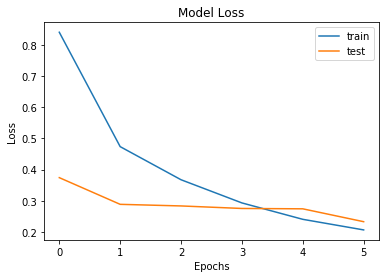

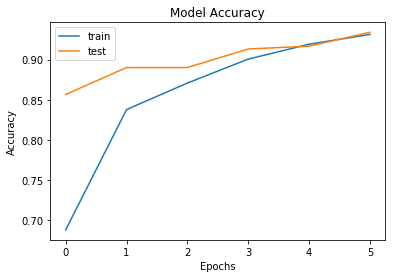

In [10]:
model.save('flowers_BN_0608_Test.h5')

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [11]:
# getting predictions on val set.
import warnings
#model = load_model('./flowers_BN.h5')
pred = model.predict(x_test)
pred_digits = np.argmax(pred,axis=1)

# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

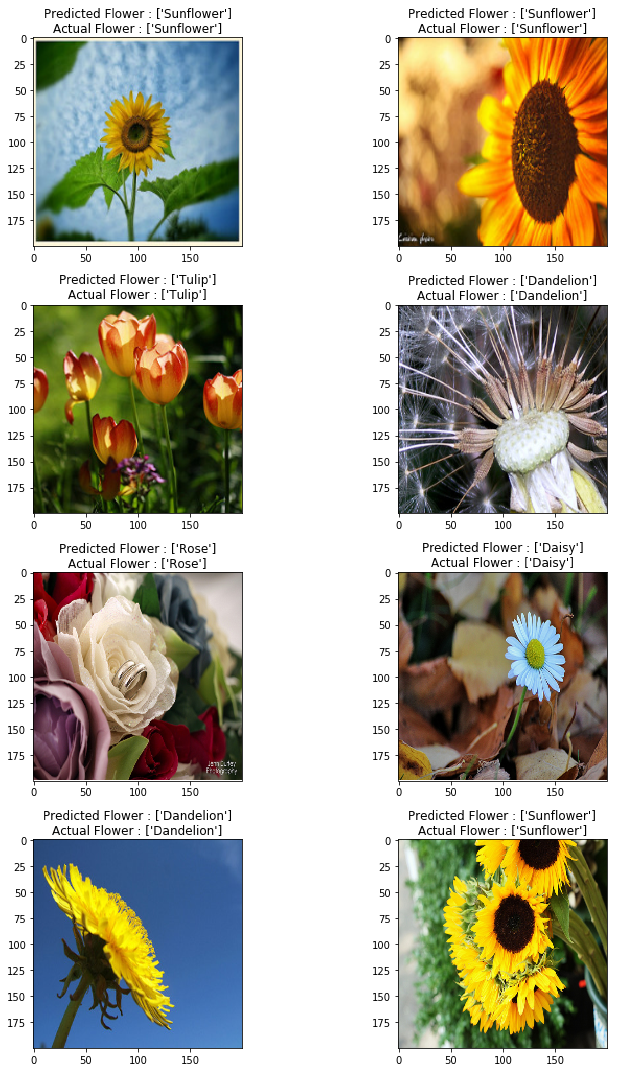

In [12]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

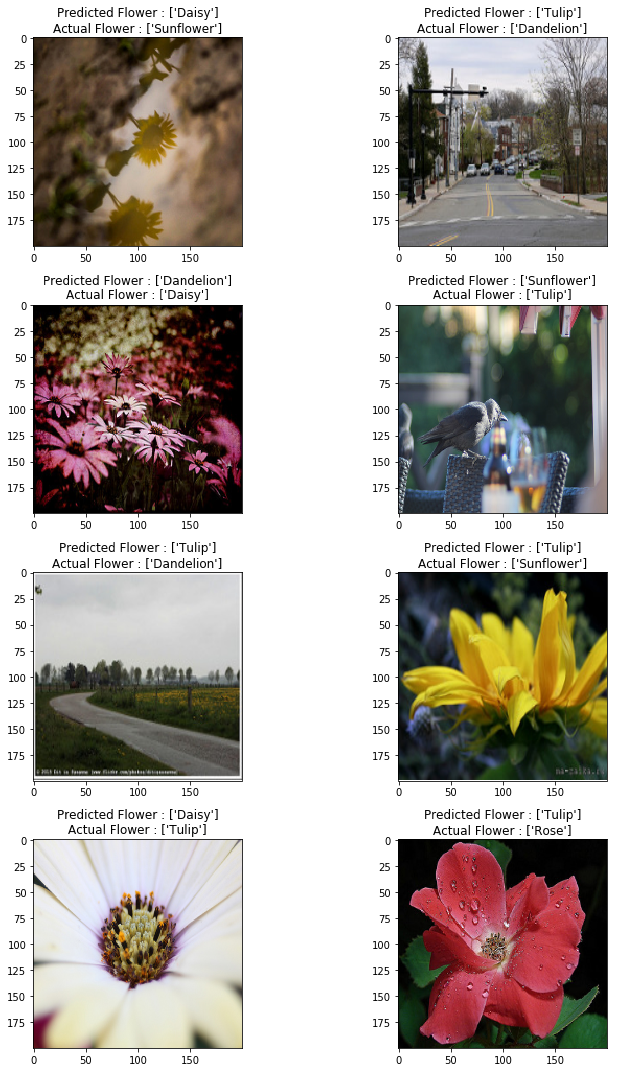

In [13]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1